In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import os
from random import choice
import tensorflow as tf
# # Utility function to load and preprocess an image
def preprocess_image(image_path, target_size=(105, 105)):
    image = tf.keras.preprocessing.image.load_img(image_path, color_mode='grayscale', target_size=target_size)
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = image / 255.0  # Normalize to [0, 1]
    return image

def data_aug(img):
    # img = preprocess_aug(img)
    data = []
    for i in range(5):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

# # Create positive and negative pairs
def create_pairs(base_dir, random_dir):
    base_images = [os.path.join(base_dir, f) for f in os.listdir(base_dir)]
    random_images = [os.path.join(random_dir, f) for f in os.listdir(random_dir)]
    pairs = []
    labels = []
    
    # Positive pairs
    for img_path in base_images:
        pair = [preprocess_image(img_path), preprocess_image(choice(base_images))]
        pairs.append(pair)
        labels.append(1)  # Similar
    
    # Negative pairs
    for img_path in base_images:
        pair = [preprocess_image(img_path), preprocess_image(choice(random_images))]
        pairs.append(pair)
        labels.append(0)  # Dissimilar
    
    return np.array(pairs), np.array(labels)

# Load and create pairs
base_dir = r'D:\MSIS\SEM_II\Artificial_Intelligence\Project\test'
random_dir = r'D:\MSIS\SEM_II\Artificial_Intelligence\Project\data\negative'
pairs, labels = create_pairs(base_dir, random_dir)

# Split data into training and testing
pairs_train, pairs_test, labels_train, labels_test = train_test_split(pairs, labels, test_size=0.2, stratify = labels, random_state=42)

# data generator 
datagen = ImageDataGenerator()

# Training the model using a generator
def generate_batch(pairs, labels, batch_size):
    while True:
        batch_index = np.random.choice(len(pairs), size=batch_size, replace=False)
        batch_pairs = pairs[batch_index]
        batch_labels = labels[batch_index]
        yield [batch_pairs[:, 0], batch_pairs[:, 1]], batch_labels



In [35]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

def initialize_base_model():
    input = Input(shape=(105, 105, 1))
    x = Conv2D(64, (10, 10), activation='relu')(input)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(128, (7, 7), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(128, (4, 4), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(256, (4, 4), activation='relu')(x)
    x = Flatten()(x)
    x = Dense(4096, activation='sigmoid')(x)
    return Model(inputs=input, outputs=x)

# Initialize the base model
base_model = initialize_base_model()

# Define the two input images
input_image_1 = Input(shape=(105, 105, 1))
input_image_2 = Input(shape=(105, 105, 1))

# Generate encodings 
encoded_image_1 = base_model(input_image_1)
encoded_image_2 = base_model(input_image_2)

# Add a custom layer to compute the absolute difference between the encodings
L1_layer = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))
L1_distance = L1_layer([encoded_image_1, encoded_image_2])

# Add a dense layer with a sigmoid unit to generate the similarity score
prediction = Dense(1, activation='sigmoid')(L1_distance)

# Connect the inputs with the outputs
siamese_net = Model(inputs=[input_image_1, input_image_2], outputs=prediction)

lr_schedule = ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=100,
    decay_rate=0.96,
    staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# optimizer = Adam(learning_rate=1e-5)
# Compile the model
siamese_net.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# model training
batch_size = 15
history = siamese_net.fit(
    generate_batch(pairs_train, labels_train, batch_size),
    steps_per_epoch=len(pairs_train) // batch_size,
    epochs=30,
    validation_data=generate_batch(pairs_test, labels_test, batch_size),
    validation_steps=len(pairs_test) // batch_size
)


Epoch 1/30
15/15 [==============================] - 2s 69ms/step - loss: 0.5617 - accuracy: 0.6311 - val_loss: 0.4459 - val_accuracy: 0.7333
Epoch 2/30
15/15 [==============================] - 1s 44ms/step - loss: 0.4877 - accuracy: 0.7422 - val_loss: 0.4385 - val_accuracy: 0.7333
Epoch 3/30
15/15 [==============================] - 1s 45ms/step - loss: 0.4358 - accuracy: 0.8178 - val_loss: 0.3700 - val_accuracy: 0.8667
Epoch 4/30
15/15 [==============================] - 1s 45ms/step - loss: 0.5396 - accuracy: 0.7289 - val_loss: 0.4910 - val_accuracy: 0.8222
Epoch 5/30
15/15 [==============================] - 1s 43ms/step - loss: 0.4159 - accuracy: 0.8311 - val_loss: 0.3345 - val_accuracy: 0.8889
Epoch 6/30
15/15 [==============================] - 1s 42ms/step - loss: 0.4687 - accuracy: 0.7600 - val_loss: 0.3822 - val_accuracy: 0.8667
Epoch 7/30
15/15 [==============================] - 1s 43ms/step - loss: 0.3388 - accuracy: 0.8578 - val_loss: 0.2835 - val_accuracy: 0.8667
Epoch 8/30
15

In [78]:
siamese_net.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 105, 105, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_9 (InputLayer)           [(None, 105, 105, 1  0           []                               
                                )]                                                                
                                                                                                  
 model_4 (Functional)           (None, 4096)         38947648    ['input_8[0][0]',                
                                                                  'input_9[0][0]']          

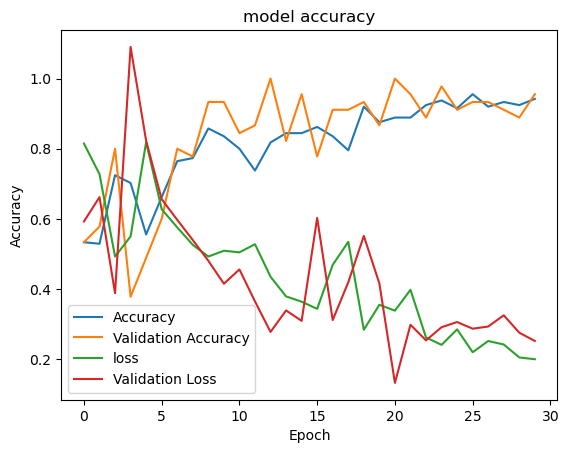

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Accuracy','Validation Accuracy','loss','Validation Loss'])
plt.show()


In [79]:
img1 = preprocess_image(r"C:\Users\vivek\Downloads\test3.jpg")
img2 = preprocess_image(r"C:\Users\vivek\Downloads\test6.jpg")


In [80]:
img3= preprocess_image(r"C:\Users\vivek\Downloads\test2.jpg")
img4 = preprocess_image(r"C:\Users\vivek\Downloads\test1.jpg")


##  Prediction Test

#### Prediction on Random images

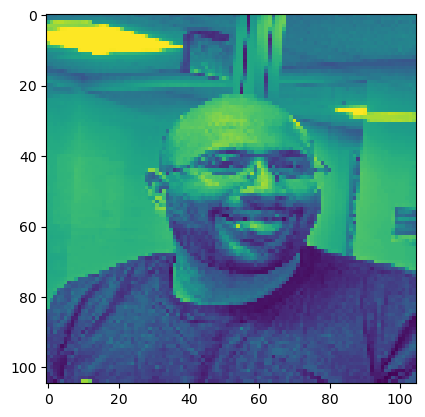

In [81]:
import matplotlib.pyplot as plt
plt.imshow(img1)

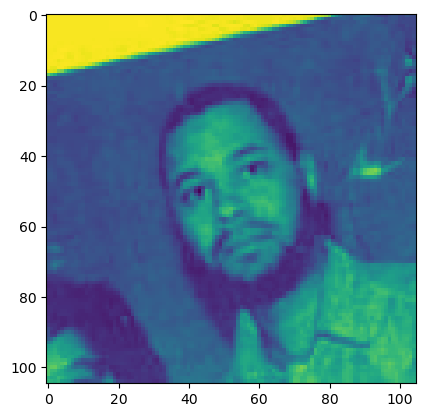

In [82]:
plt.imshow(img2)

In [83]:
siamese_net.predict([tf.expand_dims(img1, axis=0),tf.expand_dims(img2, axis=0)])

1/1 [==============================] - 0s 39ms/step


array([[0.00206518]], dtype=float32)

####  prediction on same photos in different angles

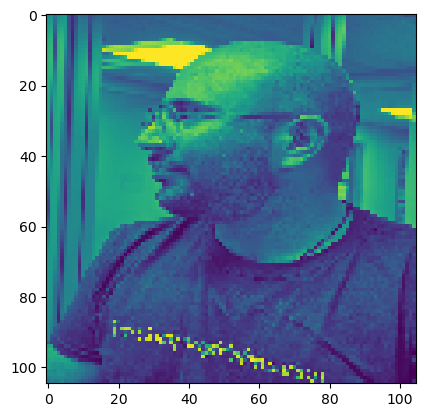

In [84]:
plt.imshow(img3)

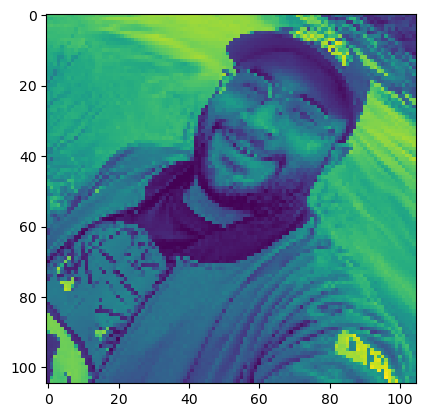

In [85]:
plt.imshow(img4)

In [86]:
siamese_net.predict([tf.expand_dims(img3, axis=0),tf.expand_dims(img4, axis=0)])

1/1 [==============================] - 0s 48ms/step


array([[0.550778]], dtype=float32)

In [87]:
os.getcwd()

'D:\\MSIS\\SEM_II'